## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
data = pd.read_csv('breast-cancer-wisconsin.data', header = None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
#filtering out non-numerical columns
catCols = []
for col in data.columns:
    if data[col].dtype == 'object':
        catCols.append(col)

In [5]:
#dumping rows with invalid feature values
print("Shape before removing invalid data " + str(data.shape))
for col in catCols:
    idx = data[data[col] == "?"].index
    data.drop(idx, inplace = True)
print("Shape after removing invalid data " + str(data.shape))

Shape before removing invalid data (699, 11)
Shape after removing invalid data (683, 11)


In [6]:
#converting categorical columns into numericals cols
for col in catCols:
    data[col] = data[col].astype('float64')

In [7]:
#dumping the 0 column as it is just the ID of the patient
data.drop(0, axis = 1, inplace = True)

In [8]:
data.head()

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


In [9]:
#splitting the data into features and labels
X = data.drop(10, axis = 1)
y = data[10]

In [10]:
#converting labels into +1 for malignant and 0 for benign
y = np.where(y == 4, 1, 0)

In [11]:
#Splitting the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
#Normalizing the dataset
mu = X_train.mean(axis = 0)
std = X_train.std(axis = 0)
X_train = (X_train - mu) / std
X_val = (X_val - mu) / std

In [13]:
#Concatenating ones for the training and testing set
X_train = np.concatenate((X_train, np.ones((X_train.shape[0],1))), axis = 1)
X_val = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis = 1)

## Modelling

In [14]:
#Created a model using OOP
class LogisticRegression():
    #Initialization
    def __init__(self):
        #Initialize all the required params to None
        self.w = None #weights
        self.lr = None #learning rate
        self.optimizer = None #optimizer(sgd and mbgd)
        self.batchSize = None #batch size
        self.pred = None #predictions
        self.rn = None #random state for reproducable results
        self.loss = None #loss at every ecoph
        
    #Fitting the model 
    def fit(self, X_train, y_train, lr, optimizer, batchSize = 1, epochs = 100, random_state = 42):
        self.loss = [] #create an empty list to store loss at every epoch
        self.rn = np.random.RandomState(random_state) #set random state
        self.w = self.rn.rand(X_train.shape[1]) #initialize w randomly
        self.lr = lr #set learning rate
        self.optimizer = optimizer #set optimizer
        if self.optimizer == "sgd":
            self.batchSize = 1 #minibatch with batch size = 1 is same as sgd
        elif self.optimizer == "mbgd":
            if batchSize > X_train.shape[0]:
                raise Exception("Error: Batch Size can not be more than training set") #Error Handling
            self.batchSize = batchSize #set batch size
        elif self.optimizer != "sgd" and self.optimizer != "mbgd":
            raise Exception("Error: Invalid Optimizer") #Error handling
        self.epochs = epochs #set epochs
        self.__minibatch__(X_train, y_train) #start training
    
    #Minibatch Gradient Descent implementation
    def __minibatch__(self, X_train, y_train):
        for _ in range(self.epochs):
            batches = int(X_train.shape[0] / self.batchSize) #calculate the number of batches
            batchNo = self.rn.randint(batches) #randomly selcet a batch
            XBatch = X_train[batchNo * self.batchSize : (batchNo + 1) * self.batchSize] #select features from that batch
            yBatch = y_train[batchNo * self.batchSize : (batchNo + 1) * self.batchSize] #select labels from that batch
            g = self.__gradient__(XBatch, yBatch) #calculate gradient for the given batch
            self.__loss__(XBatch, yBatch) #calculate loss for the given batch
            self.w -= (self.lr * g) #update weights
    
    #Gradient implementation
    def __gradient__(self, XBatch, yBatch):
        logit = self.__logit__(XBatch) #get logit of the features i.e, f(x)
        return np.dot((logit - yBatch).T, XBatch) #return the gradient
    
    #Logit implementation
    def __logit__(self, XBatch):
        exp = np.dot(XBatch, self.w)
        e = np.exp(-exp)
        return 1 / (1 + e)
    
    #Loss Function
    def __loss__(self, XBatch, yBatch):
        logit = self.__logit__(XBatch) #get logit of the features i.e, f(x)
        loss = np.dot(yBatch, np.log(logit)) + np.dot((1 - yBatch), np.log(1 - logit)) #calculate loss
        self.loss.append(-loss) #append loss to the self.loss array
    
    #Return Weights
    def getWeights(self):
        return self.w
    
    #Prediction
    def predict(self, X_val):
        self.pred = np.dot(X_val, self.w)
        self.pred = np.where(self.pred >= 0, 1, 0)
        return self.pred
    
    #Plotting the grpah to see how well our model is doing
    def plot(self):
        plt.plot(range(self.epochs), self.loss)
        if self.optimizer == 'sgd':
            plt.title("Stochastic Gradient Descent")
        else:
            plt.title("Minibatch Gradient Descent")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

## Working

In [15]:
lr = LogisticRegression()

In [16]:
lr.fit(X_train, y_train, 0.001, "sgd", 100)

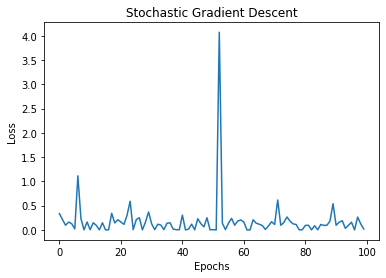

In [17]:
lr.plot()

In [18]:
lr.getWeights()

array([0.37750204, 0.95547114, 0.73649654, 0.60229693, 0.16052998,
       0.16168686, 0.06398766, 0.87223365, 0.60507308, 0.69634322])

In [19]:
pred = lr.predict(X_val)
pred

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0])

## Checking the accuracy of the model

In [20]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        79
           1       0.95      0.97      0.96        58

    accuracy                           0.96       137
   macro avg       0.96      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137



## Hyperparameter tuning

In [21]:
#KCV helper function
def kcvHelper(X_train, y_train, X_val, y_val, lr, opt, batchSize, epochs, random_state):
    op = None
    if opt == "sgd": #optimize for sgd
        for l in lr:
            model = LogisticRegression()
            model.fit(X_train, y_train, l, opt, 1, epochs, random_state)
            pred = model.predict(X_val)
            report = classification_report(y_val, pred, output_dict = True)
            op = {
                "Precision" : report['1']['precision'],
                "Optimizer" : opt,
                "Learning Rate" : l,
                "Batch Size" : 1,
                "Epochs" : epochs,
                "Random State" : random_state
            }
    elif opt == "mbgd": #optimize for mbgd
        for b in batchSize:
            for l in lr:
                model = LogisticRegression()
                model.fit(X_train, y_train, l, opt, b, epochs, random_state)
                pred = model.predict(X_val)
                report = classification_report(y_val, pred, output_dict = True)
                op = {
                    "Precision" : report['1']['precision'],
                    "Optimizer" : opt,
                    "Learning Rate" : l,
                    "Batch Size" : b,
                    "Epochs" : epochs,
                    "Random State" : random_state
                }
    return op

#Implemented KCV with focus on precision of malignant tumors
def kcv(k, X, y, lr, optimizer, batchSize, epochs = 100, random_state = 42):
    dataSize = int(len(X) / k)
    precision = 0
    finalOP = {}
    for i in range(k):
        X_val = X[i * dataSize:(i+1) * dataSize]
        y_val = y[i * dataSize:(i+1) * dataSize]
        X_train = np.concatenate((X[:i * dataSize], X[(i+1) * dataSize:]), axis = 0)
        y_train = np.concatenate((y[:i * dataSize], y[(i+1) * dataSize:]), axis = 0)
        for opt in optimizer:
            op = kcvHelper(X_train, y_train, X_val, y_val, lr, opt, batchSize, epochs, random_state)
            if op['Precision'] > precision:
                precision = op['Precision']
                finalOP = op
    return finalOP

In [22]:
#initializing params for KCV
k = 5
lr = [0.0001, 0.001, 0.01]
optimizer = ['sgd', 'mbgd']
batchSize = [50, 100, 200, 300, 400]
epochs = 100
random_state = 42

In [23]:
optimalOP = kcv(5, X_train, y_train, lr, optimizer, batchSize, epochs, random_state)

In [24]:
optimalOP

{'Precision': 0.9722222222222222,
 'Optimizer': 'mbgd',
 'Learning Rate': 0.01,
 'Batch Size': 400,
 'Epochs': 100,
 'Random State': 42}

In [25]:
#Using optimal params to construct a model
optimalModel = LogisticRegression()
optimalModel.fit(X_train, y_train, optimalOP['Learning Rate'], optimalOP['Optimizer'], 
                 optimalOP['Batch Size'], optimalOP['Epochs'], optimalOP['Random State'])

In [26]:
pred = optimalModel.predict(X_val)

In [27]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        79
           1       0.98      0.91      0.95        58

    accuracy                           0.96       137
   macro avg       0.96      0.95      0.95       137
weighted avg       0.96      0.96      0.96       137



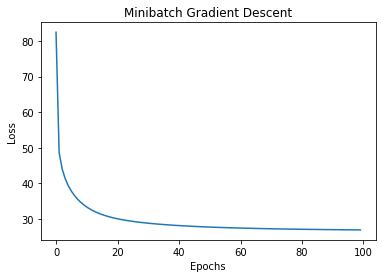

In [28]:
optimalModel.plot()